In [1]:
import os
import cv2
import dlib
import openface
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from skimage import io
from skimage.transform import resize
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


### Face Landmarks

In [2]:
# Docs:
# - http://openface-api.readthedocs.io/en/latest/index.html
# - http://dlib.net/python/index.html

# Pre-trained face detection model
# http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
predictor_model = 'Resources/shape_predictor_68_face_landmarks.dat'

# Create a HOG face detector using the built-in dlib class
face_detector = dlib.get_frontal_face_detector()
face_pose_predictor = dlib.shape_predictor(predictor_model)
face_aligner = openface.AlignDlib(predictor_model)

### Loading and Pre-Processing Data

In [3]:
labels = []
images = []
size = 150

path = 'Data/yalefaces'
for p in os.listdir(path):
    images.append(io.imread(os.path.join(path, p), as_grey=True))
    labels.append(int(p.split('.')[0].replace('subject', ''))-1) # original from 1 to 15
    
n_targets = len(set(labels))

In [4]:
print('Number of unique labels:', len(set(labels)))
print('Number of images:', len(labels))

Number of unique labels: 15
Number of images: 166


In [5]:
def get_face(image, size):
    # Run the HOG face detector on the image data
    detected_faces = face_detector(image, 1)
    # win = dlib.image_window()
    # win.set_image(image)
    # print("Found {} face(s) in the image file {}".format(len(detected_faces), labels[0]))
    # Loop through each face we found in the image
    for i, face_rect in enumerate(detected_faces):
        # Detected faces are returned as an object with the coordinates 
        # of the top, left, right and bottom edges
        # print("- Face #{} found at Left: {} Top: {} Right: {} Bottom: {}".format(i, face_rect.left(), face_rect.top(), face_rect.right(), face_rect.bottom())) 
        # Get the the face's pose
        pose_landmarks = face_pose_predictor(image, face_rect)
        # win.add_overlay(pose_landmarks)
        # Use openface to calculate and perform the face alignment
        return face_aligner.align(size, image, face_rect, landmarkIndices=openface.AlignDlib.OUTER_EYES_AND_NOSE)
    return None

In [6]:
# Discarding images where faces weren't found
X = []
y = []
b = []
for i, image in enumerate(images):
    face = get_face(image, size)
    if face is None:
        b.append(i)
    else:
        X.append(face)
        y.append(labels[i])

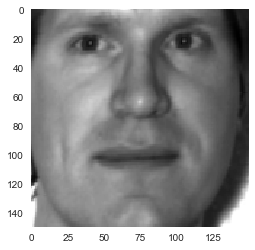

In [7]:
plt.figure()
plt.grid(False)
plt.imshow(X[0], cmap='gray')

In [8]:
X = np.array(X)
y = np.array(y)

print('Bad images:', b)
print('Remanescent images:', len(X))s

Bad images: [7, 51, 117]
Remanescent images: 163


In [9]:
print ('Training array shape:', np.array(X).shape)

Training array shape: (163, 150, 150)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [11]:
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train.astype('float32').reshape(X_train.shape[0], size*size))
X_test = scaler.transform(X_test.astype('float32').reshape(X_test.shape[0], size*size))

In [12]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [13]:
X_train = X_train.reshape(X_train.shape[0], size, size, 1)
X_test = X_test.reshape(X_test.shape[0], size, size, 1)

### Model

In [14]:
def plot_history(history, x, y):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(fisize=(x, y))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

In [15]:
input_shape = (size, size, 1)

model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_targets, activation='softmax'))

In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(122, 150, 150, 1)
(122, 15)
(41, 150, 150, 1)
(41, 15)


In [ ]:
optim = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optim, loss='categorical_crossentropy',  metrics=['accuracy'])
hist = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=0, validation_data=(X_test, y_test))

C:\Users\paula.ceccon.ribeiro\AppData\Local\Continuum\Anaconda3\lib\site-packages\keras\models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [ ]:
plot_history(hist, 10, 20)